<div style="background-color:rgba(78, 188, 130, 0.05); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(78, 188, 130, 1.0); color: #000000;">

<img src="figs/qr_logo.png" width="700"/>

<h1><strong>Quantum Summer School</strong></h1>

<h2><strong>Episode 14</strong></h2>

<h3><strong>Capstone: 100-Qubit QAOA & Road Ahead</strong></h3>

</div>

*In this session, we will wrap up the series by solving a max-cut problem with the QAOA algorithm with 100 qubits!*

**Note:** This tutorial draws from both Qiskit and Quantum Ring's QAOA Max-Cut tutorials.

<div style="background-color:rgba(255, 248, 240, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 0, 1.0); color: #000000;">

## Objectives
1. Recap QAOA and complete a small example
2. Run QAOA with 100 qubits

<div/>

## Setup & Imports

In [1]:
!pip install -q qiskit_ibm_runtime
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from datetime import datetime
from collections import defaultdict
from typing import Sequence
from scipy.optimize import minimize
from IPython.display import clear_output

matplotlib.rcParams.update({"font.size": 10})

from QuantumRingsLib import QuantumRingsProvider
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_histogram
from qiskit import transpile
from quantumrings.toolkit.qiskit import QrBackendV2
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import Session
from quantumrings.toolkit.qiskit import QrEstimatorV2 as Estimator
from quantumrings.toolkit.qiskit import QrSamplerV2 as Sampler

# Provider & backend (toolkit)
provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits=2)


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Helpers

plot_parameter_evolution: helper for plotting the gamma and beta values for each optimizer iteration

In [2]:
def plot_parameter_evolution():
    """
    Plot the evolution of parameters during optimization.
    This function assumes `parameter_history` is a global variable
    containing the parameter values for each evaluation.
    """
    global parameter_history

    # Ensure there's data to plot
    if not parameter_history:
        return

    clear_output(wait=True)

    plt.figure(figsize=(10, 6))
    num_params = len(parameter_history[0])
    for i in range(num_params):
        param_values = [params[i] for params in parameter_history]
        plt.plot(param_values, label=f"Parameter {i + 1}")

    plt.xlabel("Evaluation")
    plt.ylabel("Parameter Value")
    plt.title("Parameter Evolution During Optimization")
    plt.legend()
    plt.grid(True)
    plt.show()

to_bitstring: convert integers to binary strings

In [3]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

plot_result: plot the best result partition from the QAOA circuit on the graph

In [4]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G, seed=1), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)

In [29]:
# we will construct this in Section 1, but define here in case you want to skip to Section 2
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))

In [30]:
# we will construct this in Section 1, but define here in case you want to skip to Section 2
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

# 1. Small-scale QAOA

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

In Episode 12, we learned how QAOA works and used it to solve two simple graph problems: max-cut and minimum vertex cover. If you want to review the details of QAOA, you can find it there. In a nutshell, QAOA is a special case of a VQE. We are just trying to minimize the expectation value of a Hamiltonian, but the type of Hamiltonian is very specific. VQE generally speaking lends itself well to problems in like finding the ground state energy of a molecule, whereas QAOA specifically is intended for solving combinatorial problems.

Suppose we are given a connected graph $G$ with vertices $V$ and edges $E$. We want to partition $G$ into two sets, which we can also think of as selecting some subset of vertices and leaving the rest not selected. We can label selected with a "1" and not selected with a "0" (notice how well this maps to qubits). We then "cut" every edge which connects two vertices in different sets. The max-cut problem asks: what is the partition of $G$ which maximizes the number of cut edges?

Classically, we can formulate the max-cut problem as an optimization problem. Let $x_i\in \{0,1\}$ be the state of vertex $i$ (0 is not selected and 1 is selected). Consider the function:
$$
f(i,j) = 2 x_i x_j - x_i - x_j ,
$$
If $x_i=x_j=0$ or $x_i=x_j=1$, then $f(i,j) = 0$. If $x_i\neq x_j$, then $f(i,j) = -1$. Minimizing this function will give us our max-cut, because we are rewarded for cutting edges between vertices $i$ and $j$ if $x_i\neq x_j$. So:
$$
\text{max. number of cuts} = \min_{x\in \{0, 1\}^n} \sum_{(i,j)\in E}  2 x_i x_j - x_i - x_j.
$$

Now we need to translate this to something our quantum computer understands! Consider the following Hamiltonian: $H=\sigma^z_1 \sigma^z_{2}$. There are four possibilities for the energy:

| Qubit $1$ state     | Qubit $2$ state     | Energy ($\langle H \rangle$)    |
|--------------|--------------|--------------|
| 0 | 0 | 1 |
| 0 | 1 | -1 |
| 1 | 0 | -1 |
| 1 | 1 | 1 |

We can see that when the two qubits are in the same state, the energy is 1, and when the two qubits are in different states, the energy is -1. This exactly matches our classical function. So our cost Hamiltonian for the whole graph should be:
$$ H_C = \sum_{\langle i,j \rangle\in E(G)} \sigma^z_i \sigma^z_{j} $$

QAOA works by applying $p$ layers of a cost unitary and mixing unitary. We pick vectors $\vec{\gamma}, \vec{\beta}$ of length $p$. For the $k$th layer, the cost unitary is:

$$U_C(\gamma_k) = e^{-i \gamma_k H_C} = \prod_{\langle i,j \rangle\in E(G)} e^{-i \gamma_k \sigma^z_i \sigma^z_{j}}$$

and the mixing unitary is:

$$ U_B(\beta_k) = \prod_{i\in V} e^{-i \beta_k \sigma^x_i}$$

We will use qiskit's QAOAAnsatz to prepare this parameterized layered circuit, then use a classical optimizer to minimize the expectation value of our cost Hamiltonian. Let's do it with 5 qubits, then we will do it with 100 qubits.

</div>

Initialize your problem by creating a graph with $n=5$ nodes.


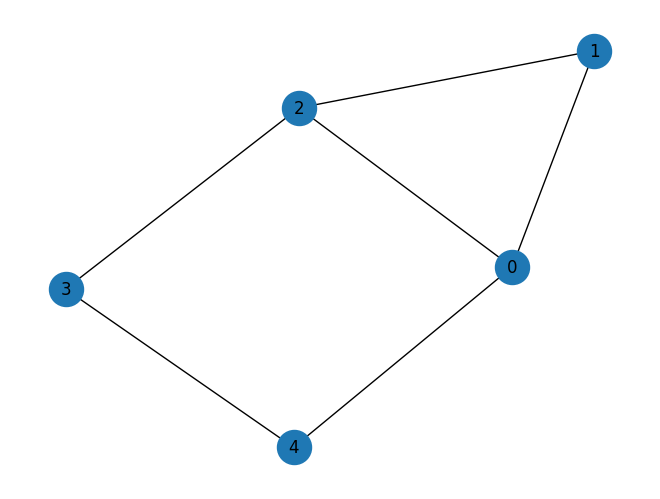

In [8]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [9]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [10]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw()

┌────────────────────────────┐ ░ ┌─┐            
   q_0: ┤0                           ├─░─┤M├────────────
        │                            │ ░ └╥┘┌─┐         
   q_1: ┤1                           ├─░──╫─┤M├─────────
        │                            │ ░  ║ └╥┘┌─┐      
   q_2: ┤2 QAOA(γ[0],β[0],γ[1],β[1]) ├─░──╫──╫─┤M├──────
        │                            │ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤3                           ├─░──╫──╫──╫─┤M├───
        │                            │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤4                           ├─░──╫──╫──╫──╫─┤M├
        └────────────────────────────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════════════════════════╩══╩══╩══╩══╩═
                                          0  1  2  3  4

In [11]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

### Optimize circuits for quantum hardware execution


In [12]:
# Create the backend, transpile the circuit, and define the number of qubits
backend = QrBackendV2(provider=provider, num_qubits = circuit.num_qubits)
qc_transpiled = transpile(circuit, backend)
qc_transpiled.draw(fold=False, idle_wires=False)

┌───┐                                                            »
q_0 -> 0 ┤ H ├─■──────────────■─────────────────────────────■─────────────»
         ├───┤ │              │ZZ(2.0*γ[0])                 │             »
q_2 -> 1 ┤ H ├─┼──────────────■──────────────■──────────────┼─────────────»
         ├───┤ │ZZ(2.0*γ[0])                 │ZZ(2.0*γ[0])  │             »
q_1 -> 2 ┤ H ├─■─────────────────────────────■──────────────┼─────────────»
         ├───┤                                              │ZZ(2.0*γ[0]) »
q_4 -> 3 ┤ H ├──────────────────────────────────────────────■─────────────»
         ├───┤                                                            »
q_3 -> 4 ┤ H ├────────────────────────────────────────────────────────────»
         └───┘                                                            »
 meas: 5/═════════════════════════════════════════════════════════════════»
                                                                          »
«         ┌──────────────┐                                              »
«q_0 -> 0 ┤ Rx(2.0*β[0]) ├────────────────■─────────────────────────────»
«         └──────────────┘                │             ┌──────────────┐»
«q_2 -> 1 ─────────────────■──────────────┼─────────────┤ Rx(2.0*β[0]) ├»
«         ┌──────────────┐ │              │ZZ(2.0*γ[1]) └──────────────┘»
«q_1 -> 2 ┤ Rx(2.0*β[0]) ├─┼──────────────■─────────────────────────────»
«         └──────────────┘ │                            ┌──────────────┐»
«q_4 -> 3 ─────────────────┼──────────────■─────────────┤ Rx(2.0*β[0]) ├»
«                          │ZZ(2.0*γ[0])  │ZZ(2.0*γ[0]) ├──────────────┤»
«q_3 -> 4 ─────────────────■──────────────■─────────────┤ Rx(2.0*β[0]) ├»
«                                                       └──────────────┘»
« meas: 5/══════════════════════════════════════════════════════════════»
«                                                                       »
«                                                      ┌──────────────┐»
«q_0 -> 0 ─■─────────────────────────────■─────────────┤ Rx(2.0*β[1]) ├»
«          │ZZ(2.0*γ[1])                 │             └──────────────┘»
«q_2 -> 1 ─■──────────────■──────────────┼─────────────────────────────»
«                         │ZZ(2.0*γ[1])  │             ┌──────────────┐»
«q_1 -> 2 ────────────────■──────────────┼─────────────┤ Rx(2.0*β[1]) ├»
«                                        │ZZ(2.0*γ[1]) └──────────────┘»
«q_4 -> 3 ───────────────────────────────■─────────────────────────────»
«                                                                      »
«q_3 -> 4 ─────────────────────────────────────────────────────────────»
«                                                                      »
« meas: 5/═════════════════════════════════════════════════════════════»
«                                                                      »
«                                                         ░ ┌─┐            
«q_0 -> 0 ────────────────────────────────────────────────░─┤M├────────────
«                        ┌──────────────┐                 ░ └╥┘   ┌─┐      
«q_2 -> 1 ─■─────────────┤ Rx(2.0*β[1]) ├─────────────────░──╫────┤M├──────
«          │             └──────────────┘                 ░  ║ ┌─┐└╥┘      
«q_1 -> 2 ─┼──────────────────────────────────────────────░──╫─┤M├─╫───────
«          │                             ┌──────────────┐ ░  ║ └╥┘ ║    ┌─┐
«q_4 -> 3 ─┼──────────────■──────────────┤ Rx(2.0*β[1]) ├─░──╫──╫──╫────┤M├
«          │ZZ(2.0*γ[1])  │ZZ(2.0*γ[1])  ├──────────────┤ ░  ║  ║  ║ ┌─┐└╥┘
«q_3 -> 4 ─■──────────────■──────────────┤ Rx(2.0*β[1]) ├─░──╫──╫──╫─┤M├─╫─
«                                        └──────────────┘ ░  ║  ║  ║ └╥┘ ║ 
« meas: 5/═══════════════════════════════════════════════════╩══╩══╩══╩══╩═
«                                                            0  1  2  3  4

### Execute using Qiskit primitives

There are two choices for primitives for the backend: the Sampler and the Estimator. The choice of primitive depends on what type of measurement you want to run on the quantum computer. For the minimization of $H_c$, use the Estimator since the measurement of the cost function is simply the expectation value of $\langle H_c \rangle$.

Define the circuit with initial parameters.

In [13]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [14]:
evaluation_count = 0
start_time = None
parameter_history = []
objective_func_vals = []

In [15]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    global evaluation_count, start_time, parameter_history, objective_func_vals

    if evaluation_count == 0:
        start_time = time.time()

    evaluation_count += 1

    # Transform observable and run job
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    parameter_history.append(params)
    objective_func_vals.append(cost)

    elapsed_time = time.time() - start_time

    # Print progress
    clear_output(wait=True)
    print(f"Evaluation #{evaluation_count}")
    print(f"Current Parameters: {params}")
    print(f"Current Cost: {cost}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    # Plot parameter evolution
    plot_parameter_evolution()

    return cost

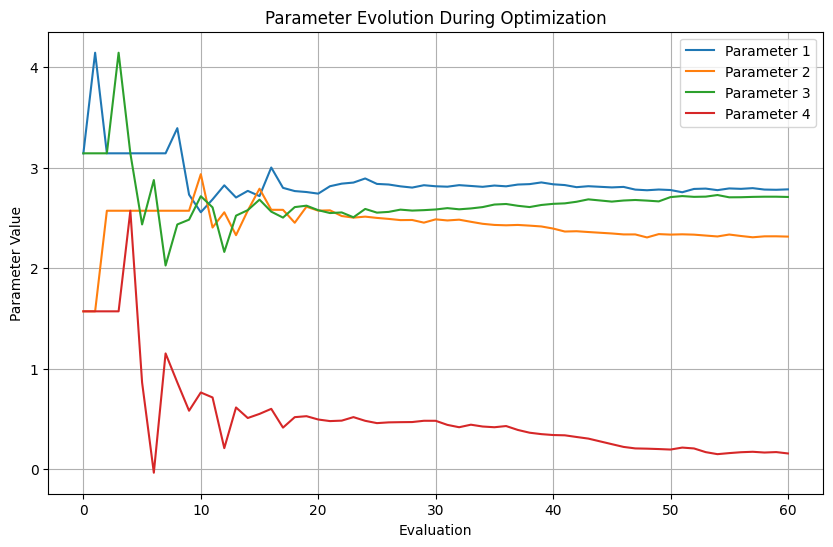

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.4448265000313336
       x: [ 2.783e+00  2.314e+00  2.708e+00  1.581e-01]
    nfev: 61
   maxcv: 0.0


In [16]:
objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    estimator = Estimator(backend=backend)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(qc_transpiled, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
        options={'maxiter': 100},
    )
    print(result)

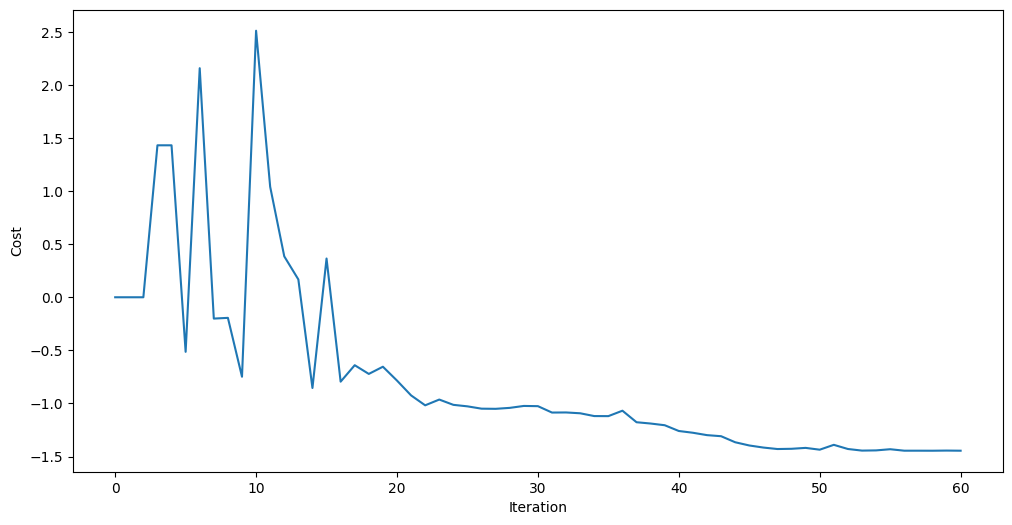

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Once you have found the optimal parameters for the circuit, we assign these parameters and sample the final distribution obtained with the optimized parameters. Here is where the *Sampler* primitive should be used since it is the probability distribution of bitstring measurements which correspond to the optimal cut of the graph.

**Note:** This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state - for example, `010101110000...` - which corresponds to a candidate solution $x$ to our initial optimization problem.

In [18]:
optimized_circuit = qc_transpiled.assign_parameters(result.x)
optimized_circuit.draw(fold=False, idle_wires=False)

┌───┐                                                    »
q_0 -> 0 ┤ H ├─■────────────■─────────────────────────■───────────»
         ├───┤ │            │ZZ(5.4154)               │           »
q_2 -> 1 ┤ H ├─┼────────────■────────────■────────────┼───────────»
         ├───┤ │ZZ(5.4154)               │ZZ(5.4154)  │           »
q_1 -> 2 ┤ H ├─■─────────────────────────■────────────┼───────────»
         ├───┤                                        │ZZ(5.4154) »
q_4 -> 3 ┤ H ├────────────────────────────────────────■───────────»
         ├───┤                                                    »
q_3 -> 4 ┤ H ├────────────────────────────────────────────────────»
         └───┘                                                    »
 meas: 5/═════════════════════════════════════════════════════════»
                                                                  »
«         ┌────────────┐                                                       »
«q_0 -> 0 ┤ Rx(5.5666) ├──────────────■───────────────────────────■────────────»
«         └────────────┘              │            ┌────────────┐ │ZZ(0.31617) »
«q_2 -> 1 ───────────────■────────────┼────────────┤ Rx(5.5666) ├─■────────────»
«         ┌────────────┐ │            │ZZ(0.31617) └────────────┘              »
«q_1 -> 2 ┤ Rx(5.5666) ├─┼────────────■────────────────────────────────────────»
«         └────────────┘ │                         ┌────────────┐              »
«q_4 -> 3 ───────────────┼────────────■────────────┤ Rx(5.5666) ├──────────────»
«                        │ZZ(5.4154)  │ZZ(5.4154)  ├────────────┤              »
«q_3 -> 4 ───────────────■────────────■────────────┤ Rx(5.5666) ├──────────────»
«                                                  └────────────┘              »
« meas: 5/═════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                     ┌────────────┐              »
«q_0 -> 0 ───────────────■────────────┤ Rx(4.6273) ├──────────────»
«                        │            └────────────┘              »
«q_2 -> 1 ─■─────────────┼───────────────────────────■────────────»
«          │ZZ(0.31617)  │            ┌────────────┐ │            »
«q_1 -> 2 ─■─────────────┼────────────┤ Rx(4.6273) ├─┼────────────»
«                        │ZZ(0.31617) └────────────┘ │            »
«q_4 -> 3 ───────────────■───────────────────────────┼────────────»
«                                                    │ZZ(0.31617) »
«q_3 -> 4 ───────────────────────────────────────────■────────────»
«                                                                 »
« meas: 5/════════════════════════════════════════════════════════»
«                                                                 »
«                                      ░ ┌─┐            
«q_0 -> 0 ─────────────────────────────░─┤M├────────────
«         ┌────────────┐               ░ └╥┘   ┌─┐      
«q_2 -> 1 ┤ Rx(4.6273) ├───────────────░──╫────┤M├──────
«         └────────────┘               ░  ║ ┌─┐└╥┘      
«q_1 -> 2 ─────────────────────────────░──╫─┤M├─╫───────
«                       ┌────────────┐ ░  ║ └╥┘ ║    ┌─┐
«q_4 -> 3 ─■────────────┤ Rx(4.6273) ├─░──╫──╫──╫────┤M├
«          │ZZ(0.31617) ├────────────┤ ░  ║  ║  ║ ┌─┐└╥┘
«q_3 -> 4 ─■────────────┤ Rx(4.6273) ├─░──╫──╫──╫─┤M├─╫─
«                       └────────────┘ ░  ║  ║  ║ └╥┘ ║ 
« meas: 5/════════════════════════════════╩══╩══╩══╩══╩═
«                                         0  1  2  3  4

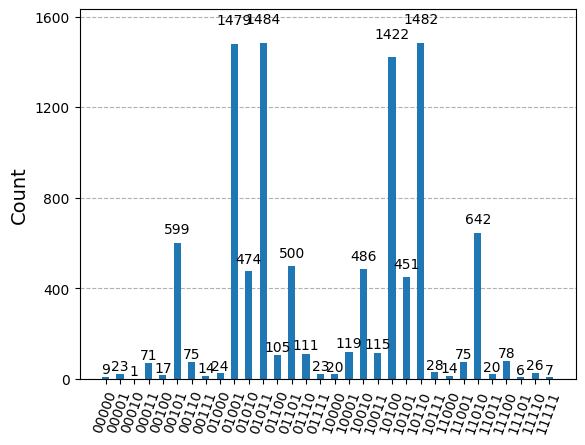

In [19]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
plot_histogram(counts_bin)

### Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for your original problem. In this case, you are interested in the bitstring with the highest probability as this determines the optimal cut. The symmetries in the problem allow for four possible solutions, and the sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that four of the bitstrings are distictively more likely than the rest.

In [20]:
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 0, 1, 0]


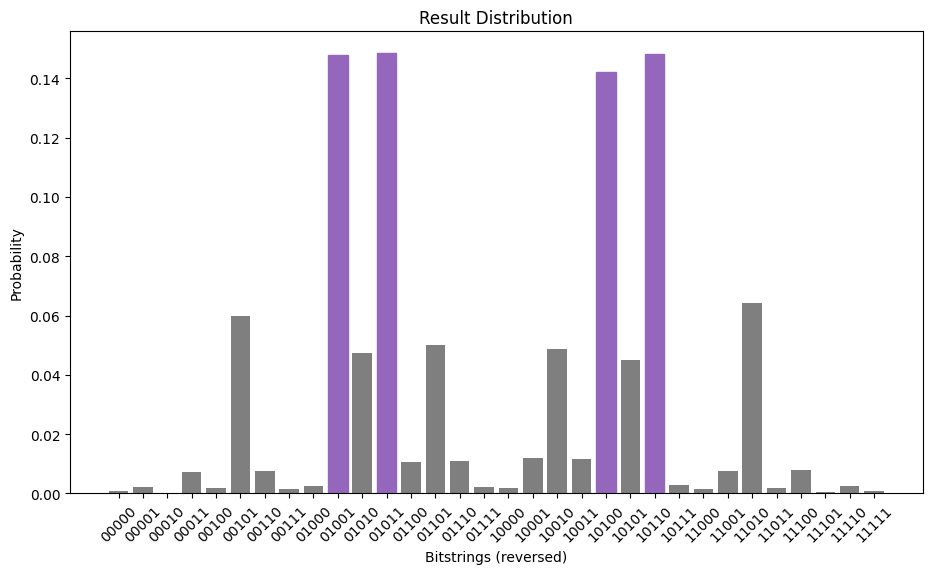

In [21]:
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    idxs = np.where(values == value)[0]
    for idx in idxs:
        positions.append(idx)

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

### Visualize best cut

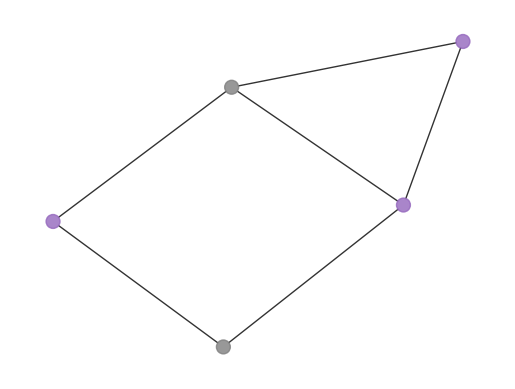

In [22]:
plot_result(graph, most_likely_bitstring)

And calculate the value of the cut


In [23]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 5


## 2. QAOA with 100 Qubits

Let's do it all again, but now with a "utility-scale" problem. With 100 qubits, we can find the max cut for a graph with 100 nodes! We can map real-world combinatorial problems, like vehicle routing or optimizing schedules or portfolio optimization, to a 100 node graph problem, which could then be solved with QAOA.

In [5]:
edge_list = [
(1, 0, 1.0),
(4, 3, 1.0),
(8, 7, 1.0),
(11, 10, 1.0),
(17, 12, 1.0),
(19, 18, 1.0),
(23, 22, 1.0),
(25, 24, 1.0),
(26, 16, 1.0),
(28, 27, 1.0),
(30, 29, 1.0),
(33, 20, 1.0),
(36, 32, 1.0),
(38, 37, 1.0),
(40, 39, 1.0),
(42, 41, 1.0),
(43, 34, 1.0),
(47, 46, 1.0),
(51, 50, 1.0),
(54, 45, 1.0),
(55, 49, 1.0),
(56, 52, 1.0),
(59, 58, 1.0),
(61, 60, 1.0),
(65, 64, 1.0),
(69, 68, 1.0),
(72, 62, 1.0),
(73, 66, 1.0),
(90, 75, 1.0),
(78, 77, 1.0),
(81, 80, 1.0),
(83, 82, 1.0),
(86, 85, 1.0),
(93, 87, 1.0),
(89, 88, 1.0),
(91, 79, 1.0),
(96, 95, 1.0),
(98, 97, 1.0),
(3, 2, 1.0),
(15, 4, 1.0),
(6, 5, 1.0),
(10, 9, 1.0),
(12, 11, 1.0),
(18, 14, 1.0),
(16, 8, 1.0),
(20, 19, 1.0),
(22, 21, 1.0),
(27, 26, 1.0),
(29, 28, 1.0),
(31, 30, 1.0),
(34, 24, 1.0),
(47, 35, 1.0),
(39, 38, 1.0),
(41, 40, 1.0),
(43, 42, 1.0),
(45, 44, 1.0),
(49, 48, 1.0),
(60, 53, 1.0),
(64, 54, 1.0),
(58, 57, 1.0),
(63, 62, 1.0),
(66, 65, 1.0),
(68, 67, 1.0),
(70, 69, 1.0),
(76, 75, 1.0),
(77, 71, 1.0),
(80, 79, 1.0),
(82, 81, 1.0),
(85, 84, 1.0),
(88, 87, 1.0),
(89, 74, 1.0),
(98, 91, 1.0),
(92, 83, 1.0),
(94, 90, 1.0),
(14, 0, 1.0),
(2, 1, 1.0),
(5, 4, 1.0),
(7, 6, 1.0),
(9, 8, 1.0),
(13, 12, 1.0),
(30, 17, 1.0),
(21, 20, 1.0),
(22, 15, 1.0),
(24, 23, 1.0),
(26, 25, 1.0),
(32, 31, 1.0),
(39, 33, 1.0),
(35, 28, 1.0),
(51, 36, 1.0),
(52, 37, 1.0),
(44, 43, 1.0),
(46, 45, 1.0),
(48, 47, 1.0),
(50, 49, 1.0),
(53, 41, 1.0),
(57, 56, 1.0),
(71, 58, 1.0),
(60, 59, 1.0),
(62, 61, 1.0),
(64, 63, 1.0),
(67, 66, 1.0),
(68, 55, 1.0),
(74, 70, 1.0),
(81, 72, 1.0),
(85, 73, 1.0),
(77, 76, 1.0),
(79, 78, 1.0),
(84, 83, 1.0),
(87, 86, 1.0),
(95, 94, 1.0),
(97, 96, 1.0),
(99, 98, 1.0)
]

nodes:  100
edges:  112


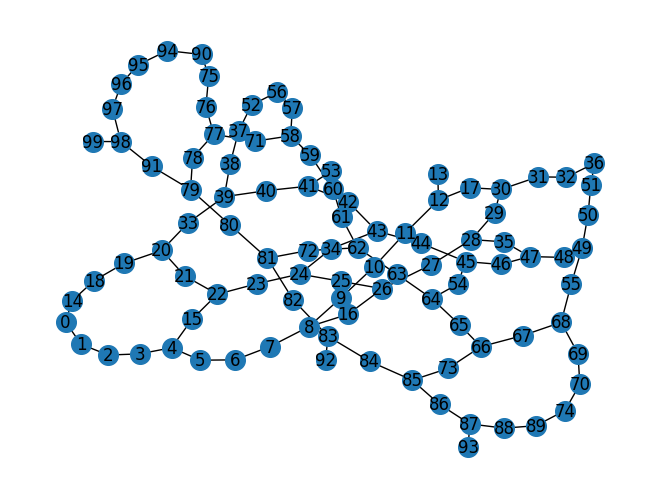

In [6]:
N = max(max(edge) for edge in edge_list) + 1
print("nodes: ", N)
print("edges: ",len(edge_list))

# Create and draw the subgraph
graph = rx.PyGraph()
graph.add_nodes_from(range(N))
graph.add_edges_from(edge_list)

pos = rx.spring_layout(graph, seed=1)
draw_graph(graph, pos=pos, node_size=200, with_labels=True, width=1)

### Map classical inputs to a quantum problem


#### Graph → Hamiltonian

First, convert the graph you want to solve directly into a Hamiltonian that is suited for QAOA.


In [9]:
max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

#### Hamiltonian → quantum circuit


In [10]:
# Experiment Parameters
p = 1  # Number of QAOA layers

initial_beta = np.pi / 2
initial_gamma = np.pi

# For p layers, we need 2 * p parameters: gamma_1, beta_1, gamma_2, beta_2, ...
init_params = [initial_gamma if i % 2 == 0 else initial_beta for i in range(2 * p)]

maxiter = 100  # Maximum iterations for the optimizer

In [11]:
circuit = QAOAAnsatz(
    cost_operator=cost_hamiltonian,
    reps=p,
)

circuit.measure_all()

In [12]:
# Create the backend, transpile the circuit, and define the number of qubits

backend = QrBackendV2(provider=provider, num_qubits = circuit.num_qubits)
qc_transpiled = transpile(circuit, backend)

### Run QAOA

To run QAOA, you must know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. Optimize these parameters by running an optimization loop on the device. The cell submits jobs until the cost function value has converged and the optimal parameters for $\gamma_k$ and $\beta_k$ are determined.


In [13]:
objective_func_vals = []
parameter_history = []
evaluation_times = []
evaluation_count = 0
start_time = time.time()

In [14]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    global evaluation_count, parameter_history, objective_func_vals
    evaluation_count += 1
    parameter_history.append(params)

    # Build the ISA hamiltonian if needed
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs  # Check what this returns. If it's a list like [0.1234], then cost[0] is needed.
    objective_func_vals.append(cost)

    elapsed = time.time() - start_time
    evaluation_times.append(elapsed)  # Store the elapsed time for this evaluation

    # Format params with 4 decimal places
    formatted_params = [f"{p:.4f}" for p in params]

    # If cost is a single-value list, use cost[0]
    formatted_cost = f"{cost[0]:.4f}"

    if evaluation_count % 1 == 0:
        elapsed = time.time() - start_time
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"{current_time} - Evaluation #{evaluation_count}, "
              f"Params={formatted_params}, Cost={formatted_cost}, Elapsed={elapsed:.2f}s")

    return cost


#### Find candidate solution for $\vec{\gamma}$ and $\vec{\beta}$.

In [17]:
start_time = time.time()
sampler = Sampler(backend=backend)

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    estimator = Estimator(backend=backend)

    estimator.options.default_shots = 1

    # Set simple error suppression/mitigation options
    sampler.options.dynamical_decoupling.enable = False
    sampler.options.twirling.enable_gates = False

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(qc_transpiled, cost_hamiltonian, estimator),
        method="COBYLA",
        options={'maxiter': maxiter },
    )
    print(result)

2025-08-24 16:19:39 - Evaluation #1, Params=['3.1416', '1.5708'], Cost=0.0000, Elapsed=0.03s
2025-08-24 16:19:39 - Evaluation #2, Params=['4.1416', '1.5708'], Cost=-0.0000, Elapsed=0.05s
2025-08-24 16:20:19 - Evaluation #3, Params=['4.1416', '2.5708'], Cost=3.2650, Elapsed=40.71s
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -8.628166150853981e-31
       x: [ 4.142e+00  1.571e+00]
    nfev: 3
   maxcv: 0.0


Once the optimal parameters from running QAOA on the device have been found, assign the parameters to the circuit


In [18]:
optimized_circuit = qc_transpiled.assign_parameters(result.x)

Finally, execute the circuit with the optimal parameters to sample from the corresponding distribution.


In [19]:
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = False
sampler.options.twirling.enable_gates = False


pub= (optimized_circuit, )
job = sampler.run([pub], shots=sampler.options.default_shots)

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}

### Post-process, return result in classical format


Check that the cost minimized in the optimization loop has converged to a certain value. The code below uses the parameters corresponding to the minimum value of the cost.

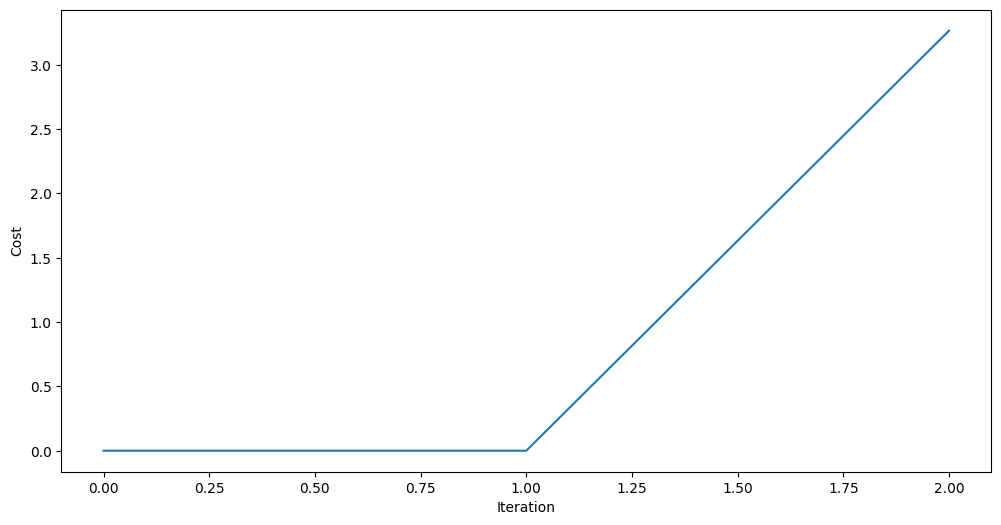

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

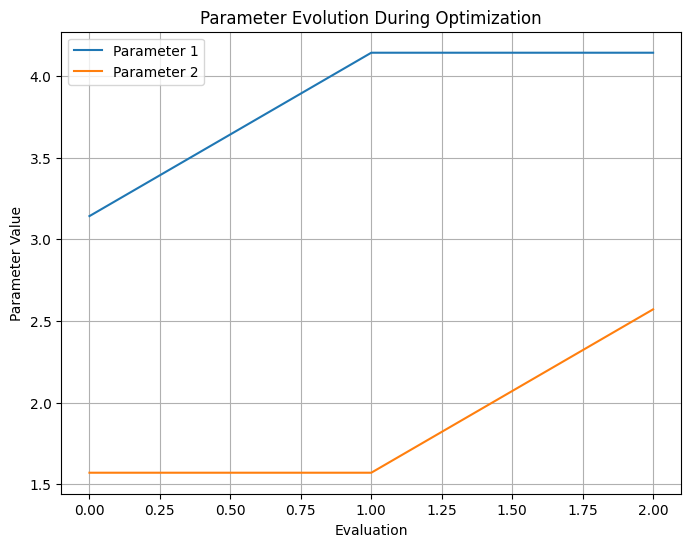

In [21]:
# Assume parameter_history is a list of lists, each inner list having length = number of parameters
num_params = len(parameter_history[0])  # number of parameters
plt.figure(figsize=(8, 6))
for i in range(num_params):
    # Extract the i-th parameter from each evaluation
    param_values = [params[i] for params in parameter_history]
    plt.plot(param_values, label=f"Parameter {i+1}")

plt.xlabel("Evaluation")
plt.ylabel("Parameter Value")
plt.title("Parameter Evolution During Optimization")
plt.legend()
plt.grid(True)
plt.show()

Given that the likelihood of each solution is low, extract the solution that corresponds to the lowest cost.


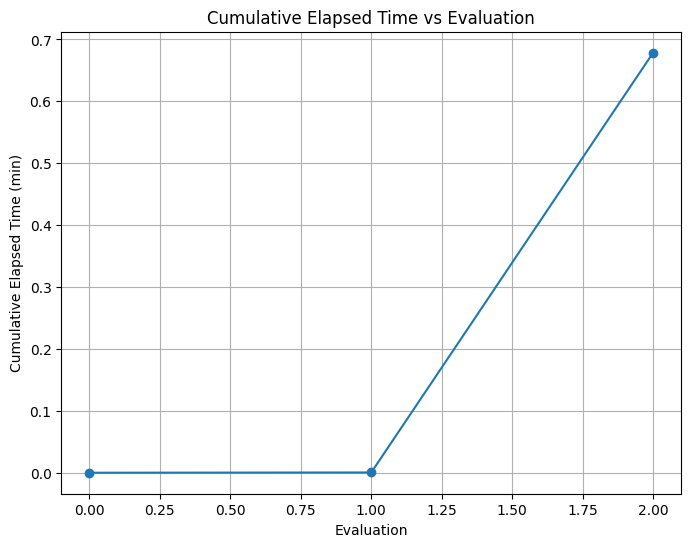

In [22]:
# Plot cumulative elapsed times
plt.figure(figsize=(8, 6))
plt.plot(np.array(evaluation_times)/60, marker='o')
plt.xlabel("Evaluation")
plt.ylabel("Cumulative Elapsed Time (min)")
plt.title("Cumulative Elapsed Time vs Evaluation")
plt.grid(True)
plt.show()

Average time per evaluation: 20.34 seconds


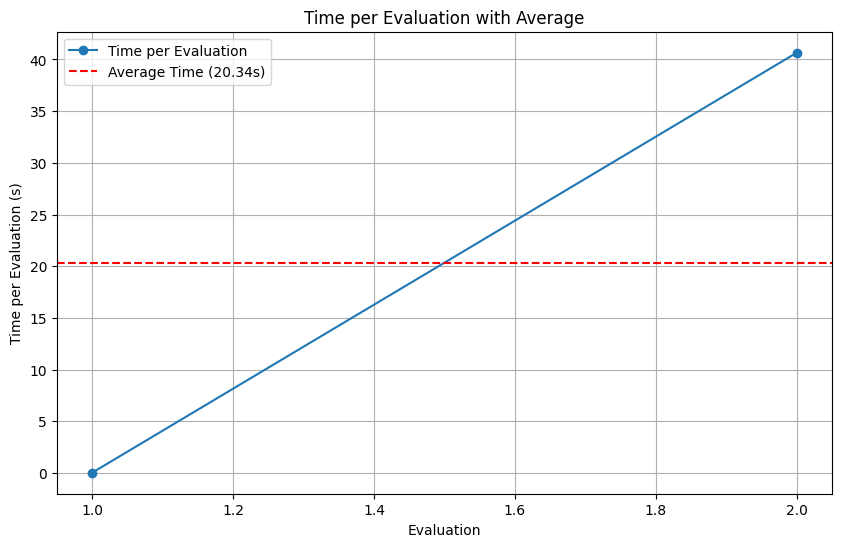

In [23]:
# Compute per-evaluation times from cumulative times if needed
time_per_evaluation = [
    evaluation_times[i] - evaluation_times[i - 1]
    for i in range(1, len(evaluation_times))
]

# Calculate the average time
average_time = np.mean(time_per_evaluation)

# Print the average time
print(f"Average time per evaluation: {average_time:.2f} seconds")

# Plot per-evaluation times
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(evaluation_times)), time_per_evaluation, marker='o', label="Time per Evaluation")
plt.axhline(y=average_time, color='r', linestyle='--', label=f"Average Time ({average_time:.2f}s)")
plt.xlabel("Evaluation")
plt.ylabel("Time per Evaluation (s)")
plt.title("Time per Evaluation with Average")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol
            min_cost = fval

    return min_sol

best_sol = best_solution(final_distribution_int, cost_hamiltonian)
best_sol_bitstring = to_bitstring(int(best_sol), len(graph))
best_sol_bitstring.reverse()

print("Result bitstring:", best_sol_bitstring)

Result bitstring: [1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]


Next, visualize the cut. Nodes of the same color belong to the same group.


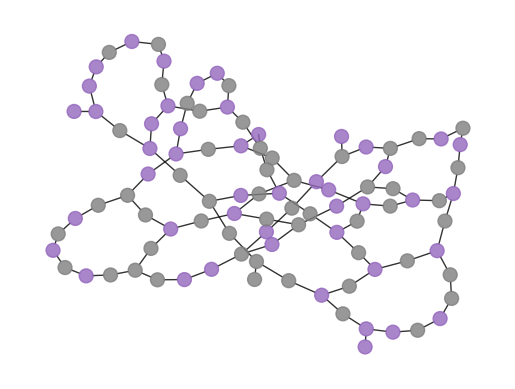

In [27]:
plot_result(graph, best_sol_bitstring)

And calculate the the value of the cut


In [31]:
cut_value= evaluate_sample(best_sol_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 80


In [32]:
# Extract final parameter values
final_params = result.x
print("Final Parameters:", final_params)

Final Parameters: [4.14159265 1.57079633]


Now you need to compute the objective value of each sample that you measured on the quantum computer. The sample with the lowest objective value is the solution returned by the quantum computer.


In [33]:
# auxiliary function to help plot cumulative distribution functions
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)


def plot_cdf(dist, ax, title):
    _plot_cdf(dist, ax, "C1",)
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)

# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Convert the samples to values of the objective function."""

    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob

    return objective_values

In [35]:
result_dist = samples_to_objective_values(final_distribution_int, cost_hamiltonian)

Finally, you can plot the cumulative distribution function to visualize how each sample contributes to the total probability distribution and the corresponding objective value. The horizontal spread shows the range of objective values of the samples in the final distribution. Ideally, you would see that the cumulative distribution function has "jumps" at the lower end of the objective function value axis. This would mean that few solutions with low cost have high probability of being sampled. A smooth, wide curve indicates that each sample is similarly likely, and they can have very different objective values, low or high.


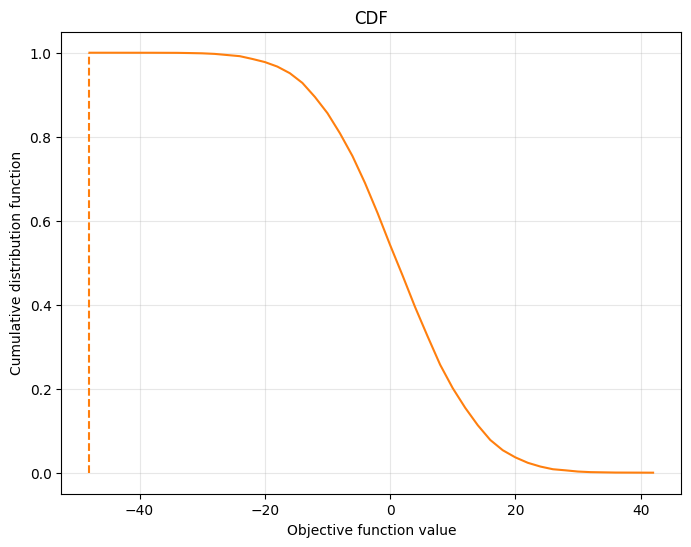

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, 'CDF')

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

**A)** We used $p=1$ layers in this 100 qubit QAOA example. Try $p=2$,$p=3$ layers. (You can use the function below to take a subgraph of our 100 qubit graph to make the optimization less computationally intensive for faster runtimes.) How does the performance of QAOA change with layer number?

**B)** In Episode 12, we learned about the minimum vertex cover and how to implement the cost Hamiltonian for that problem. Keeping the same framework here, modify the code to solve the minimum vertex problem.

**C)** With 100 qubits, we can already begin to perform optimizations for useful combinatorial problems. Can you think of a real-life example where you would want to use QAOA? Make a graph and cost Hamiltonian that describe the problem and run QAOA.

<div/>

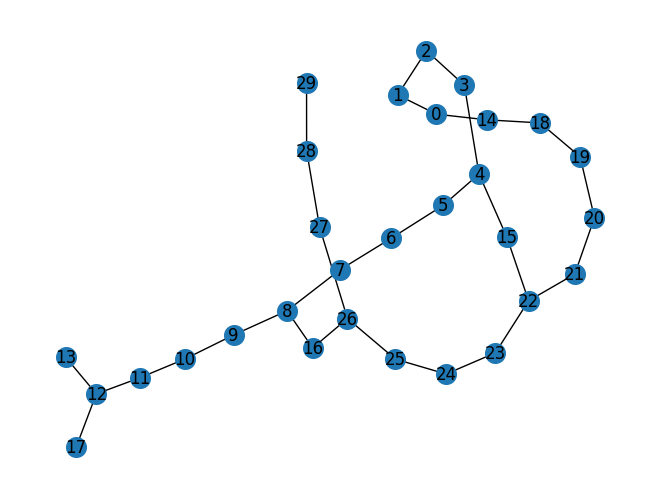

In [43]:
def get_subgraph_edge_list(full_edge_list, N):
    # Filter edges that involve only nodes < N
    return [(i, j, w) for (i, j, w) in full_edge_list if i < N and j < N]

N=30
new_edge_list = get_subgraph_edge_list(edge_list, N)

new_graph = rx.PyGraph()
new_graph.add_nodes_from(range(N))
new_graph.add_edges_from(new_edge_list)
draw_graph(new_graph, node_size=200, with_labels=True, width=1)